# 1. Imports

In [2]:
import numpy as np
from math import pi
import matplotlib.pyplot as plt
from copy import deepcopy

In [3]:
from tensorflow.keras.models import load_model

In [4]:
from tensorflow.keras.losses import MSE
from tensorflow.keras.losses import categorical_crossentropy as CCE
import tensorflow as tf

In [5]:
# Load properties from another python file
from properties import *

In [6]:
from random import random, randint

In [11]:
path_model = "ACAS_XU_tf_keras/ACASXU_1_1.h5"

# 2. Load models

In [12]:
model_11 = load_model(path_model)

In [9]:
models = []
for i in range(5):
    models.append([])
    for j in range(9):
        models[i].append(load_model("ACAS_XU_tf_keras/ACASXU_{}_{}.h5".format(i+1, j+1)))
models

[[<tensorflow.python.keras.engine.sequential.Sequential at 0x1b76935a250>,

In [8]:
model_35 = load_model("ACAS_XU_tf_keras/ACASXU_3_5.h5")

In [13]:
model_11.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_98 (Dense)             (None, 50)                300       
_________________________________________________________________
activation_98 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_99 (Dense)             (None, 50)                2550      
_________________________________________________________________
activation_99 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_100 (Dense)            (None, 50)                2550      
_________________________________________________________________
activation_100 (Activation)  (None, 50)                0         
_________________________________________________________________
dense_101 (Dense)            (None, 50)              

In [14]:
models[1][1].summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 50)                300       
_________________________________________________________________
activation_14 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 50)                2550      
_________________________________________________________________
activation_15 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 50)                2550      
_________________________________________________________________
activation_16 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 50)               

In [10]:
model_11.compile()

In [11]:
model_35.compile()

In [15]:
for i in range(5):
    for j in range(9):
        models[i][j].compile()

In [18]:
pt = np.array([1.0, 1.0, 1.0, 1.0, 1.0]).reshape(1,5)
print(models[0][0].predict(pt))
print(models[1][1].predict(pt))
print(models[2][2].predict(pt))
print(models[3][3].predict(pt))
        

[[0.19883643 0.20087564 0.19964513 0.20093843 0.19970441]]
[[0.19663781 0.19704211 0.20466787 0.19716527 0.20448694]]
[[0.19858123 0.20665449 0.19681212 0.2050748  0.19287741]]
[[0.19669315 0.19715017 0.20450674 0.19717456 0.20447537]]


In [13]:
pt = np.array([1.0, 1.0, 1.0, 1.0, 1.0]).reshape(1,5)
model_35.predict(pt)

array([[0.1967246 , 0.2045978 , 0.19686562, 0.20457308, 0.19723897]],
      dtype=float32)

# 3. FGSM

In [ ]:
def generate_adv_sample(model, x0, label, loss_function="MSE", eps=1e-5):
    # transforming into a tensorflow object
    x0_ = tf.cast(x0, tf.float32)
    
    # record our gradients
    with tf.GradientTape() as tape:
        # explicitly indicate that our input should be tacked for gradient updates
        tape.watch(x0_)

        # use our model to make predictions on the input and then compute the loss
        pred = model(x0_)
        if loss_function == "CCE":
            np_label = np.array([i==label for i in range(0,5)]).reshape((1,5))
            loss = CCE(np_label, pred)
        elif loss_function == "MSE":
            loss = MSE(label, pred)
        else:
            raise Exception("Unknown loss function '{0}'".format(loss_function))
        
        # calculate the gradients of loss with respect to the input, then compute the sign of the gradient
        gradient = tape.gradient(loss, x0_)
        signedGrad = tf.sign(gradient)

        # construct the image adversary
        adv_sample = (x0_ + (signedGrad * eps)).numpy()

        # return the adversarial sample to the calling function
        return(adv_sample)

In [ ]:
x0_adv = generate_adv_sample(model_11, pt, label = 0, loss_function = "CCE", eps=1e-3)
print(x0_adv)

In [ ]:
model_11.predict(x0_adv)

In [ ]:
np_label = np.array([int(i==2) for i in range(0,5)]).reshape((1,5))
np_label

# 4. Random search

In [22]:
def random_pts(n, prop_dom, main_dom):
    """ prop_dom is a list of domains given by intervals in a numpy 2x5 table. """
    ndom = len(prop_dom)
    ndim = main_dom.shape[1]
    
    x = np.zeros((n,ndim))
    for i in range(n): # generate the i-th point
        choosen_dom = prop_dom[randint(0,ndom-1)] # choose the input property domain for a given prop
        for k in range(ndim): # create a random coord for each dim
            boundaries = main_dom[:,k]
            if choosen_dom[0,k] != None:
                boundaries[0] = choosen_dom[0,k]
            if choosen_dom[1,k] != None:
                boundaries[1] = choosen_dom[1,k]
            x[i,k] = boundaries[0] + random()*(boundaries[1]-boundaries[0])

    return(x)

In [23]:
def normalize(x, x_mean, x_range):
    (n,k) = x.shape
    nx = np.zeros((n,k))
    for i in range(n):
        for j in range(k):
            nx[i,j] = (x[i,j]-x_mean[j])/x_range[j]
    return(nx)

In [24]:
def check_pts(model, input_pts, IP, OP):
    n = input_pts.shape[0]
    IO_check = np.zeros((n,2)) # 1st column : input checked - 2nd column : output checked
    
    norm_input = normalize(input_pts, X_mean, X_range) # normalize pts
    
    pred_pts = model.predict(norm_input) # make predictions with the model (neural net)
    
    for k in range(n):
        IO_check[k,0] = IP(input_pts[k,:]) # check input (just in case)
        IO_check[k,1] = OP(pred_pts[k,:]) # check output

    return(IO_check, pred_pts)

In [25]:
rand_inputs = random_pts(10, IP2_dom, X_dom)

In [26]:
Pcheck, pred_pts = check_pts(model_11, rand_inputs, IP1, OP1)

ValueError: setting an array element with a sequence.

In [27]:
def find_adverse(input_pts, prop_check):
    n = prop_check.shape[0]
    index = []
    for k in range(n):
        if prop_check[k,0] and not(prop_check[k,0]):
            index.append(k)
    return(input_pts[index,:])

In [115]:
adv = find_adverse(rand_inputs, Pcheck)
print(adv.shape)

(0, 5)


In [116]:
Pcheck.shape

(1000000, 2)

# 5. Statistics on random points

In [73]:
def clustering_attempt(N, dim1, dim2, model_arg1, model_arg2, show=True):
    """
    Analyse la sortie par le réseau model de N entrées générées aléatoirement, dont seules les composantes dim1 et dim2 \n
    varient (les trois autres composantes sont fixées égales à une valeur moyenne). 
    Sauvegarde la figure obtenue, et l'affiche si show waut True.
    Complexité temporelle : compter 4 secondes pour N=50000, 50 secondes pour N=500000.
    """
    model = models[model_arg1-1][model_arg2-1]
    rand_inputs = random_pts(N, [X_dom], X_dom)
    fixed_dims = np.array([0, 1, 2, 3, 4])
    fixed_dims1 = deepcopy(fixed_dims[fixed_dims != dim1])
    fixed_dims2 = deepcopy(fixed_dims1[fixed_dims1 != dim2]) #Contains 3 indexes whose values will be fixed (to the average value)
    mean_inputs = [np.mean(rand_inputs[:, i]) for i in range(5)]

    rand_inputs[:, fixed_dims2[0]] = mean_inputs[fixed_dims2[0]]*np.ones(N)
    rand_inputs[:, fixed_dims2[1]] = mean_inputs[fixed_dims2[1]]*np.ones(N)
    rand_inputs[:, fixed_dims2[2]] = mean_inputs[fixed_dims2[2]]*np.ones(N)


    rand_outputs = model.predict(normalize(rand_inputs, X_mean, X_range))
    preds = np.argmin(rand_outputs, 1)

    alabels = ["$\rho$", "$\Theta$", "$\psi$", "$v_{own}$", "$v_{int}$"]
    textlabels = ["rho", "theta", "psi", "v_own", "v_int"]

    def clustering(d1, d2):
        plt.clf()
        plt.scatter(rand_inputs[preds==0, dim1], rand_inputs[preds==0, dim2], label="COC", color="lightcoral")
        plt.scatter(rand_inputs[preds==1, dim1], rand_inputs[preds==1, dim2], label="WR",  color="cornflowerblue")
        plt.scatter(rand_inputs[preds==3, dim1], rand_inputs[preds==3, dim2], label="SR",  color="mediumblue")
        plt.scatter(rand_inputs[preds==2, dim1], rand_inputs[preds==2, dim2], label="WL",  color="springgreen")
        plt.scatter(rand_inputs[preds==4, dim1], rand_inputs[preds==4, dim2], label="SL",  color="forestgreen")
        plt.legend(bbox_to_anchor=(1.05, 1))
        plt.xlabel(alabels[dim1], fontsize = 15)
        plt.ylabel(alabels[dim2], fontsize = 15)
        plt.title("ACASXU_{}_{}".format(model_arg1, model_arg2) + ", variable components: " + alabels[d1] + ", " + alabels[d2])
        plt.savefig("D:/CentraleSupélec/Projet attaques adverses/adversarial-attack/images_clustering/" + textlabels[d1] + "-" + textlabels[d2] + "-ACASXU_{}_{}.png".format(model_arg1, model_arg2), bbox_inches='tight')
        if show:
            plt.show()
        
    clustering(dim1, dim2)

# Ordre : rho, theta, psi, v_own, v_int 



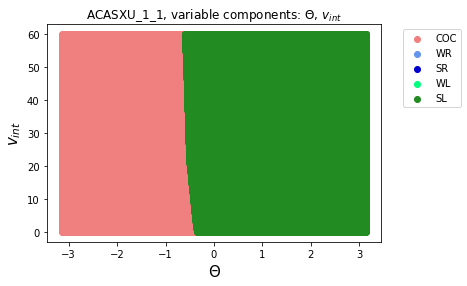

In [72]:
clustering_attempt(500000, 1, 4, 1, 1)

2.2222222222222223 % (1/45)
4.444444444444445 % (2/45)
6.666666666666667 % (3/45)
8.88888888888889 % (4/45)
11.11111111111111 % (5/45)
13.333333333333334 % (6/45)
15.555555555555555 % (7/45)
17.77777777777778 % (8/45)
20.0 % (9/45)
22.22222222222222 % (10/45)
24.444444444444443 % (11/45)
26.666666666666668 % (12/45)
28.88888888888889 % (13/45)
31.11111111111111 % (14/45)
33.333333333333336 % (15/45)
35.55555555555556 % (16/45)
37.77777777777778 % (17/45)
40.0 % (18/45)
42.22222222222222 % (19/45)
44.44444444444444 % (20/45)
46.666666666666664 % (21/45)
48.888888888888886 % (22/45)
51.111111111111114 % (23/45)
53.333333333333336 % (24/45)
55.55555555555556 % (25/45)
57.77777777777778 % (26/45)
60.0 % (27/45)
62.22222222222222 % (28/45)
64.44444444444444 % (29/45)
66.66666666666667 % (30/45)
68.88888888888889 % (31/45)
71.11111111111111 % (32/45)
73.33333333333333 % (33/45)
75.55555555555556 % (34/45)
77.77777777777777 % (35/45)
80.0 % (36/45)
82.22222222222223 % (37/45)
84.4444444444444

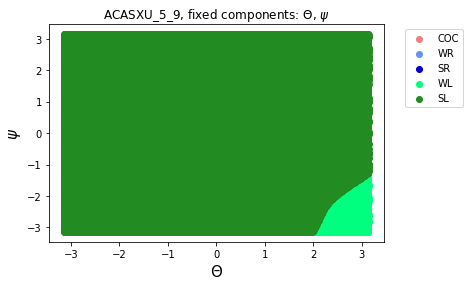

In [67]:
for j in range(1, 10):
    for i in range(1, 6):
        clustering_attempt(500000, 1, 2, i, j, False)
        print("{} % ({}/45)".format(int((i+5*j-5)*100/45), i+5*j-5))

In [ ]:
# ATTENTION - cette cellule met plusieurs heures à s'exécuter
cpt = 0
for i in range(1, 6):
    for j in range(1, 10):
        for dim1 in range(1, 6):
            for dim2 in range(1, 6):
                if dim1 < dim2:
                    clustering_attempt(500000, dim1, dim2, i, j, False)
                    cpt += 1
                    print("{} % ({}/450)".format(0.1*int(10*cpt*100/450), cpt))

In [280]:
max_values = [np.max(rand_outputs[:, i]) for i in range(5)]
min_values = [np.min(rand_outputs[:, i]) for i in range(5)]
mean_values = [np.mean(rand_outputs[:, i]) for i in range(5)]
p5 = [np.percentile(rand_outputs[:, i], 5) for i in range(5)]
p95 = [np.percentile(rand_outputs[:, i], 95) for i in range(5)]
print("Maxima: ", max_values)
print("Minima: ", min_values)
print("Mean values: ", mean_values)
print("5th percentile: ", p5)
print("95th percentile", p95)

Maxima:  [0.013805518, 0.019990219, 0.13644679, 0.9996823, 0.90597504]
Minima:  [1.2702534e-07, 0.0003105947, 7.0034184e-06, 0.019823257, 7.500304e-09]
Mean values:  [0.0009061997, 0.0041305344, 0.00979491, 0.96959287, 0.015575443]
5th percentile:  [2.3502485007043104e-07, 0.0004058257371070795, 1.1069022775700432e-05, 0.8783774644136428, 1.6267562141791813e-08]
95th percentile [0.004933892749249934, 0.015583826228976244, 0.056247988529503246, 0.9995826721191406, 0.04331267084926361]
